
<h1><b>Building a sequential neural network for classifying traffic lights.</b><h1>

I'll be using LISA traffic lights dataset from Kaggle:

https://www.kaggle.com/datasets/mbornoe/lisa-traffic-light-dataset



<h3> First, import the key features I'll need. This include not only Tensorflow and Keras, but also Pandas, Numpy, OpenCV, Scikit-Learn and other in-built modules. </h3>

In [22]:
import numpy as np
import warnings
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
from tensorflow.python import keras
from keras.layers import Flatten, Dense, Input, Dropout, concatenate, MaxPooling2D, Conv2D
from keras.models import Model, Sequential, load_model
from keras.regularizers import l1, l2
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
import random
import os
warnings.filterwarnings('ignore')

- Now we already have Tensorflow as backend and all the layers we'll need, callbacks as well.

<h3> <b>Building the model</b> </h3>

I wanted the model to receive traffic lights bounding box content as input and return the labels as output, so I built a Sequential Model to process the image
crop of the traffic light, then created a softmax-based classification layer for the labels and finally mixed it on a new model that will get the image model output as input.

-Two convolution layers will perform pixel processing vs the kernel matrix (3x3), first with 16 filters, the second with 32. 

-The MaxPooling layers will downsample the output of the convolutions by focusing on maximum values of them.

-Dropout layers will randomly disable 20% of the neurons.

-Dense layers will perform fully connected calculations and set the predicted labels (classified by softmax activation).

In [23]:
# Input layer
image_input = Input(shape=(224, 168, 3), name='image_input')

# Image processing model
image_model = Sequential()
image_model.add(Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(224, 168, 3)))
image_model.add(MaxPooling2D(pool_size=(2, 2)))
image_model.add(Dropout(0.2))

image_model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
image_model.add(MaxPooling2D(pool_size=(2, 2)))
image_model.add(Dropout(0.2))

image_model.add(Flatten())
image_model.add(Dense(128, activation='relu'))
image_model.add(Dropout(0.2))

# Connecting input layer with the image processing network 
x = image_model(image_input)
labels = Dense(3, activation='softmax', name='class_label')(x)

# Final model
model = Model(
    inputs=image_input,
    outputs=labels)

<h3> <b>Coding a custom data generator</b> </h3>




In [24]:
from keras.utils import Sequence
from skimage.transform import rotate
from random import randint

class MultiInputDataGenerator(Sequence):  

    def __init__(self, images_path, coordinates, labels, batch_size=32, shuffle=True, training=True):
        self.batch_size = batch_size
        self.all_imgs = images_path
        self.labels = labels
        self.coordinates = coordinates
        self.current_index = 0
        self.shuffle = shuffle
        self.training = training
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.all_imgs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_indices = indexes
        images, labels = self.__data_generation(batch_indices)
        return images, labels

    def __iter__(self):
        return self

    def __index__(self):
        return self.current_index

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.all_imgs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indices):
        # Generate data
        images = []
        coords = []
        labels = []
        for i in batch_indices:
            img_path = self.all_imgs[int(i)]
            coords = self.coordinates[int(i)]
            image2 = cv2.imread(img_path)
            
            x_min = int(coords[0])
            y_min = int(coords[1])
            x_max = int(coords[2])
            y_max = int(coords[3])

            cropped_img = image2[y_min:y_max, x_min:x_max] # Crops the traffic light
            cropped_img = cv2.resize(cropped_img, (168, 224))
            cropped_img = (cropped_img / 255)
            # It will modify the image input only if its set on training mode, not for the validation.
            if self.training:
              rotate_gamble = randint(0, 1)
              if rotate_gamble == 1:
                  angle = np.random.uniform(low=10, high=15)  # Ángulo aleatorio de rotación
                  cropped_img = rotate(cropped_img, angle=angle, resize=False)
              flip_gamble = randint(0, 1)
              if flip_gamble == 1:
                  cropped_img = cv2.flip(cropped_img, 0)

              gaussian_blur_gamble = randint(0,1)
              if gaussian_blur_gamble == 1:
                  kernel_size = (5, 5)  # tamaño del kernel para el desenfoque
                  cropped_img = cv2.GaussianBlur(cropped_img, kernel_size, 0)

            # Final output
            cropped_img = np.array(cropped_img)
            cropped_img = (cropped_img / 255)
            images.append(cropped_img)
            labels.append(self.labels[int(i)])
            
        return np.array(images), np.array(labels)

<h3> <b>Pre-processing data</b> </h3>

-Since LISA dataset contains frames from a video recorded inside a car, it has much more data than what I need, so I'll process it in order to just have the traffic light bounding box content, which will feed the model.

-Also I'll simplify the signal classification to 0(Green), 1(Red) and 2(Yellow).

In [25]:
print('Saving annotations...')
all_files_annotation = []

# I'll only use day training images.

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Python/traffic lights/Annotations/Annotations/dayTrain/'):
    for filename in filenames:
        if (("csv" in filename) & ("BOX" in filename)):
            all_files_annotation.append(os.path.join(dirname, filename))

print(all_files_annotation) # Checking if we catch the files we'll need
all_direcs_images = ['./dayTrain']


# Checking .csv schemas.

all_schema = [pd.read_csv(f).columns for f in all_files_annotation]
for i in range(len(all_schema) -1):
    if all_schema[i] == all_schema[i+1]:
        print("OK!")
    else:
        print("Not OK, with id as ", i)

# Concatenate all the annotation in one single file.

df_annotation = pd.concat([pd.read_csv(f, sep=";") for f in all_files_annotation])
df_annotation.index = range(df_annotation.shape[0])
df_annotation["Filename"] = df_annotation["Filename"].apply(lambda x: x.split("/")[-1]) # Changing name of the column while only keeping the name of the file.
df = df_annotation.rename({"Filename": "file_name", "Annotation tag": "signal",
                 "Upper left corner X": "l_x", "Upper left corner Y": "l_y",
                 "Lower right corner X": "r_x", "Lower right corner Y": "r_y"}, axis=1)

# Simplifying signals classification

train_imgs = []
labels = []
coordinates = []
image_paths = []

print('Coding signal keys into categorical values...')

classes_dict = {'green': 0, 'red': 1, 'yellow': 2}

for index, row in df.iterrows():

        if row['signal'] == 'go':
          df.at[index, 'signal'] = 0
          
        elif row['signal'] == 'goForward':         
          df.at[index, 'signal'] = 0

        elif row['signal'] == 'goLeft':
          
          df.at[index, 'signal'] = 0
        elif row['signal'] == 'stop':
          
          df.at[index, 'signal'] = 1
        elif row['signal'] == 'stopLeft':
          
          df.at[index, 'signal'] = 1
        elif row['signal'] == 'warning':
          
          df.at[index, 'signal'] = 2
        elif row['signal'] == 'warningLeft':
          
          df.at[index, 'signal'] = 2

# Creating a dataframe to build a balanced training dataset, since yellow lights are underepresented.

muestreo = pd.DataFrame(columns=['file_name', 'signal', 'l_x', 'l_y', 'r_x', 'r_y', 'Origin file',
       'Origin frame number', 'Origin track', 'Origin track frame number'])

red = 0
yellow = 0
green = 0


for index, row in df.iterrows():
    if row['signal'] == 0 and green < 1000:
        muestreo = muestreo.append(row)
        green +=1
    elif row['signal'] == 2 and yellow < 1000:
        muestreo = muestreo.append(row)
        yellow += 1
    elif row['signal'] == 1 and red < 1000:
        muestreo = muestreo.append(row)
        red +=1

print(muestreo['signal'].value_counts()) # Shows final dataset content

# Getting coordinates and labels.

for index, row in muestreo.iterrows():

        file = row['file_name']
        video = str(file)[7] + str(file)[8]
        video = video.replace('-','')
        train_img_full_path = os.path.join(f'/content/drive/MyDrive/Python/traffic lights/dayTrain/dayTrain/dayClip{video}/frames/' + file)
        label = row['signal']
        x_min = row['l_x']
        y_min = row['l_y']
        x_max = row['r_x']
        y_max = row['r_y'] 

        coordinates.append((x_min, y_min, x_max, y_max))
        labels.append(label)
        image_paths.append(train_img_full_path)


# Dividing dataset with train_test_split:

image_paths = np.array(image_paths)
labels = np.array(labels)
coordinates = np.array(coordinates)

train_paths, test_paths, train_coordinates, test_coordinates, train_labels, test_labels = train_test_split(image_paths, coordinates, labels, stratify=labels, test_size=0.25, random_state=42)

train_coordinates = np.array(train_coordinates, dtype='float32')
test_coordinates = np.array(test_coordinates, dtype='float32')
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
train_paths = np.array(train_paths)
test_paths = np.array(test_paths)

Saving annotations...
['/content/drive/MyDrive/Python/traffic lights/Annotations/Annotations/dayTrain/dayClip1/frameAnnotationsBOX.csv', '/content/drive/MyDrive/Python/traffic lights/Annotations/Annotations/dayTrain/dayClip10/frameAnnotationsBOX.csv', '/content/drive/MyDrive/Python/traffic lights/Annotations/Annotations/dayTrain/dayClip12/frameAnnotationsBOX.csv', '/content/drive/MyDrive/Python/traffic lights/Annotations/Annotations/dayTrain/dayClip2/frameAnnotationsBOX.csv', '/content/drive/MyDrive/Python/traffic lights/Annotations/Annotations/dayTrain/dayClip13/frameAnnotationsBOX.csv', '/content/drive/MyDrive/Python/traffic lights/Annotations/Annotations/dayTrain/dayClip11/frameAnnotationsBOX.csv', '/content/drive/MyDrive/Python/traffic lights/Annotations/Annotations/dayTrain/dayClip3/frameAnnotationsBOX.csv', '/content/drive/MyDrive/Python/traffic lights/Annotations/Annotations/dayTrain/dayClip6/frameAnnotationsBOX.csv', '/content/drive/MyDrive/Python/traffic lights/Annotations/Ann

<h3> <b> Coding the callbacks I'll use. </b> </h3>

-ModelCheckPoint, in order to save the best model.

-EarlyStopping, so the training will stop after 3 epochs without progress. Perhaps its not much patience, but due to the idiosyncracy of the problem (classifying in 3 classes by color), I thought it could be enough.

-Reduce Learning Rate On Plateau, so it will slow down this value when its not making any progress after 2 epochs.

In [26]:
# Path to save the model.
filepath = "/content/drive/MyDrive/Python/traffic lights/best_model_third.h5"

# Checkpoint callback for saving the model.
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

# Reduce learning rate on plateau.

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

<h2> <b>Compiling </b> </h2>

Setting sparse categorical crossentropy, since each class is mutually exclusive with the others.


In [27]:
losses = {
    "class_label": "sparse_categorical_crossentropy",
}

lossWeights = {
    "class_label": 1.0,
}


model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              loss_weights=lossWeights)


<h2> <b>Training </b> </h2>

This will include coding the custom image data generators in order to create a data flow and save memory.

The chosen metric for callbacks was validation loss, to focus on how much it fails against test dataset.

In [28]:
generator_train = MultiInputDataGenerator(train_paths, train_coordinates, train_labels, training=True)
generator_test = MultiInputDataGenerator(test_paths, test_coordinates, test_labels, training=False)

NUM_EPOCHS = 50

H = model.fit(
    generator_train,
    validation_data=generator_test,
    epochs=NUM_EPOCHS,
    verbose=1, callbacks=[early_stop, checkpoint, learning_rate_reduction])

Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 0.7761 - accuracy: 0.7862
Epoch 00001: val_loss improved from inf to 0.18656, saving model to /content/drive/MyDrive/Python/traffic lights/best_model_third.h5
70/70 [==============================] - 76s 1s/step - loss: 0.7761 - accuracy: 0.7862 - val_loss: 0.1866 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9862
Epoch 00002: val_loss improved from 0.18656 to 0.11009, saving model to /content/drive/MyDrive/Python/traffic lights/best_model_third.h5
70/70 [==============================] - 73s 1s/step - loss: 0.1528 - accuracy: 0.9862 - val_loss: 0.1101 - val_accuracy: 0.9986 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - ETA: 0s - loss: 0.1053 - accuracy: 0.9960
Epoch 00003: val_loss improved from 0.11009 to 0.08815, saving model to /content/drive/MyDrive/Python/traffic lights/best_model_third.h5
70/70 [====================

<h2> <b> Plotting training history </b> </h2>

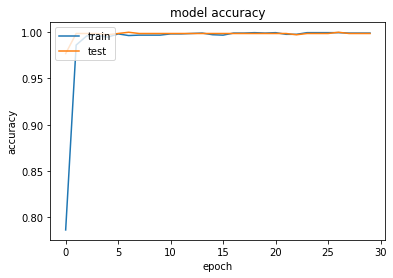

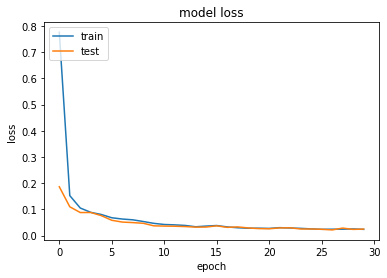

In [35]:
# Accuracy analysis
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss analysis

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<h3> <b> Using the model for inference against unseen images </b> </h3>

For that, I'll be pre-processing the data the same way I did while training, that means, cropping the traffic light image and resizing it to 224x168.


1/1 [==============================] - 0s 18ms/step


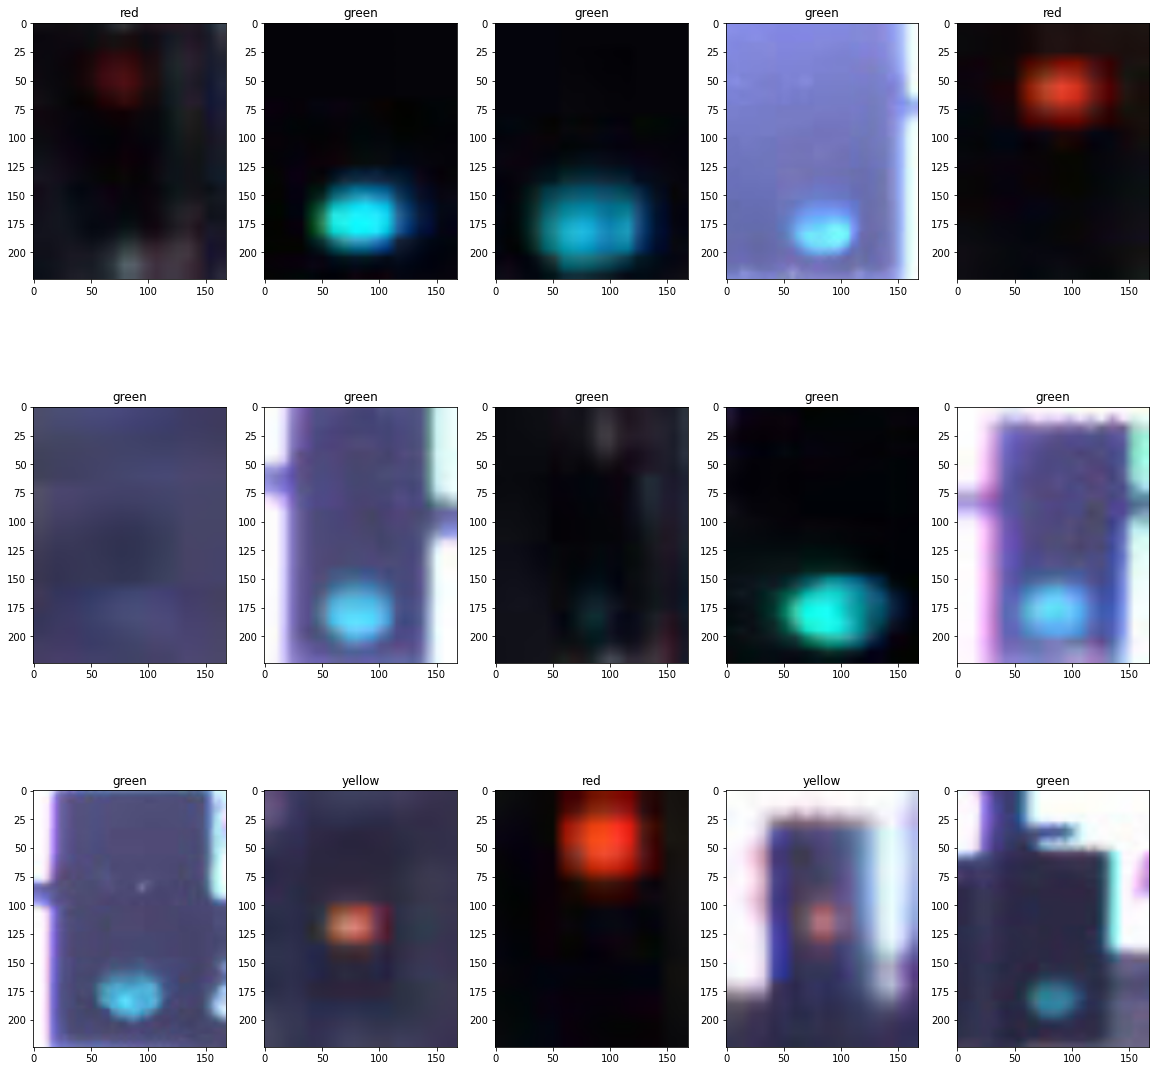

In [33]:
import matplotlib.pyplot as plt

# model = load_model('best_model_third.h5', compile=False)

annotations = pd.read_csv('/content/drive/MyDrive/Python/traffic lights/unseen_test/frameAnnotationsBOX.csv', sep=';')

image_path = '/content/drive/MyDrive/Python/traffic lights/unseen_test/'

sample = annotations.sample(n=15)
sample.index = range(sample.shape[0])
sample["Filename"] = sample["Filename"].apply(lambda x: x.split("/")[-1]) 

sample = sample.rename({"Filename": "file_name", "Annotation tag": "signal",
                 "Upper left corner X": "l_x", "Upper left corner Y": "l_y",
                 "Lower right corner X": "r_x", "Lower right corner Y": "r_y"}, axis=1)

classes_dict = {'green': 0, 'red': 1, 'yellow': 2}

image_paths = []
images = []

for index, row in sample.iterrows():

        file = row['file_name']
        video = str(file)[7] + str(file)[8]
        video = video.replace('-','')
        img_full_path = os.path.join('/content/drive/MyDrive/Python/traffic lights/unseen_test/' + file)

        x_min = row['l_x']
        y_min = row['l_y']
        x_max = row['r_x']
        y_max = row['r_y']

        image2 = cv2.imread(img_full_path)
        cropped_img = image2[y_min:y_max, x_min:x_max]
        cropped_img = cv2.resize(cropped_img, (168, 224))
        cropped_img = np.array(cropped_img)
        images.append(cropped_img)
        image_paths.append(img_full_path)

images = np.array(images)

# Setting number of images and display of the subplots
n_images = len(image_paths)
n_cols = 5
n_rows = (n_images + n_cols - 1) // n_cols

# Figure for the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

# Make a prediction and display it

predic = model.predict(images)

for ax, item, image in zip(axes.ravel(), predic.argmax(axis=-1), images):
    classes = item
    if item == 0:
        classes = 'green'
    elif item == 1:
        classes = 'red'
    elif item == 2:
        classes = 'yellow'

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.set_title(classes)
    
plt.show()
